In [1]:
import warnings
warnings.filterwarnings("ignore");

In [2]:
import pandas as pd

In [3]:
PS_reviews_data = pd.read_csv('reviews.csv')
PS_reviews_data.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


Before data pre-processing we will drop columns that are not required.

In [4]:
PS_reviews_data = PS_reviews_data[['content','score']]
PS_reviews_data.head()

,content,score
0,I cannot open the app anymore,1
1,I have been begging for a refund from this app...,1
2,Very costly for the premium version (approx In...,1
3,"Used to keep me organized, but all the 2020 UP...",1
4,Dan Birthday Oct 28,1


In [5]:
PS_reviews_data.isnull().sum()

content    0
score      0
dtype: int64

There is no null values in data.

In [6]:
import seaborn as sns

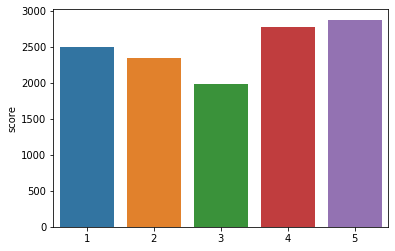

In [7]:
sns.barplot(x=PS_reviews_data.score.value_counts().index,y=PS_reviews_data.score.value_counts())

We will segregate the data into 2 groups for better analysis,
```
1. Rating from 1-2 will be negative(0)
2. Rating from 4-5 will be positive(1)
```



In [8]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\faisa\AppData\Roaming\nltk_data...


True

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

In [10]:
def analyze_sentiment(data):
    analysis = SIA().polarity_scores(data)
    if analysis['compound'] > 0:    # Converting rating 3 with positive sentiment as group 1
        return 'Positive'
    elif analysis['compound'] == 0: # Converting rating 3 with neutral sentiment as group to drop
        return 'Neutral'
    else:                           # Converting rating 3 with negative sentiment as group 0
        return 'Negative'

In [11]:
PS_reviews_data['sentiment_neutral_ratings'] = PS_reviews_data[PS_reviews_data.score == 3].content.apply(analyze_sentiment)

In [12]:
PS_reviews_data[PS_reviews_data.score == 3].head()

,content,score,sentiment_neutral_ratings
400,"This still works pretty well, but I'm not a fa...",3,Positive
401,Good app. Annoying pop up every morning on my ...,3,Positive
402,I haven't used they made an effort from there ...,3,Negative
403,"29.9. Nothing new, I've already reconciled to ...",3,Positive
404,I've been a satisfied user of Any.do since Mar...,3,Positive


In [13]:
PS_reviews_data[PS_reviews_data.sentiment_neutral_ratings == 'Neutral'].head() # Drop these records

,content,score,sentiment_neutral_ratings
426,Too many options and gets too fancy for an app...,3,Neutral
429,Way too expensive; if there was a monthly opti...,3,Neutral
438,Hyyy,3,Neutral
441,Don't know,3,Neutral
445,We need a monthly payment terms. Currently it ...,3,Neutral


In [14]:
PS_reviews_data = PS_reviews_data[PS_reviews_data.sentiment_neutral_ratings != 'Neutral'] # Discarding neutral records

In [15]:
def rating_seg(df):
  score_ = 0
  if df['score'] <= 2:
    score_ = 0
  elif df['score'] == 3:
    if df['sentiment_neutral_ratings'] == 'Positive':
      score_ = 0
    else:
      score_ = 1
  else:
    score_ = 1
  return score_


In [16]:
PS_reviews_data['new_score'] = PS_reviews_data.apply(rating_seg, axis=1)
PS_reviews_data[['score','new_score']].sample(frac=1.0).head() # verifying data

,score,new_score
10215,4,1
12202,4,1
7163,2,0
10546,5,1
4967,2,0


In [17]:
PS_reviews_data.drop(['sentiment_neutral_ratings'],inplace=True,axis=1)

# Data Pre-Processing

ML models require data to be in numeric format, since we are dealinng with textual data, we will have to clean textual data and then convert it into numeric format.

Below are the steps to clean any textual data,

## 1. Replacing/Dropping NULL values

In [18]:
PS_reviews_data.isnull().sum()
# Since our data has no null values will be skip this step

content      0
score        0
new_score    0
dtype: int64

## 2. Converting to LOWER case

In [19]:
PS_reviews_data['content'].head()
# from below data we can verify that our data has uppercase letters, we will convert our data in lower case

0                        I cannot open the app anymore
1    I have been begging for a refund from this app...
2    Very costly for the premium version (approx In...
3    Used to keep me organized, but all the 2020 UP...
4                                  Dan Birthday Oct 28
Name: content, dtype: object

In [20]:
PS_reviews_data['new_content'] = PS_reviews_data['content'].apply(lambda x: str(x).lower())
PS_reviews_data[['content','new_content']].head()

,content,new_content
0,I cannot open the app anymore,i cannot open the app anymore
1,I have been begging for a refund from this app...,i have been begging for a refund from this app...
2,Very costly for the premium version (approx In...,very costly for the premium version (approx in...
3,"Used to keep me organized, but all the 2020 UP...","used to keep me organized, but all the 2020 up..."
4,Dan Birthday Oct 28,dan birthday oct 28


## 3. REMOVE NON-ALPHA DATA(DIGITS,PUNCTUATIONS,DIACRITICS)

In [21]:
PS_reviews_data.loc[PS_reviews_data['new_content'].str.contains("[^a-z\s]"),'new_content'].head()

# From below data we can notice that there are many rows that has non-aplhabet data

2    very costly for the premium version (approx in...
3    used to keep me organized, but all the 2020 up...
4                                  dan birthday oct 28
5    it has changed how i viewed my different lists...
6    i'm only looking for a grocery list app but ev...
Name: new_content, dtype: object

In [22]:
PS_reviews_data['new_content'] = PS_reviews_data['new_content'].str.replace(r'[^a-zA-Z\s]', ' ') # replacing junk data with space
PS_reviews_data[['content','new_content']].head()

,content,new_content
0,I cannot open the app anymore,i cannot open the app anymore
1,I have been begging for a refund from this app...,i have been begging for a refund from this app...
2,Very costly for the premium version (approx In...,very costly for the premium version approx in...
3,"Used to keep me organized, but all the 2020 UP...",used to keep me organized but all the up...
4,Dan Birthday Oct 28,dan birthday oct


In [23]:
PS_reviews_data.loc[PS_reviews_data['new_content'].str.contains("[^a-z\s]"),'new_content']
# Our data now contains only alphabets

Series([], Name: new_content, dtype: object)

In [24]:
PS_reviews_data[['content','new_content']].head().style.set_properties( **{'width': '400px'})

,content,new_content
0,I cannot open the app anymore,i cannot open the app anymore
1,I have been begging for a refund from this app for over a month and nobody is replying me,i have been begging for a refund from this app for over a month and nobody is replying me
2,Very costly for the premium version (approx Indian Rupees 910 per year). Better to download the premium version of this app from apkmos website and use it. Microsoft to do list app is far more better.,very costly for the premium version approx indian rupees per year better to download the premium version of this app from apkmos website and use it microsoft to do list app is far more better
3,"Used to keep me organized, but all the 2020 UPDATES have made a mess of things !!! Y cudn't u leave well enuf alone ??? Guess ur techies feel the need to keep making changes to justify continuing to collect their salary !!! 🤤🤤🤤",used to keep me organized but all the updates have made a mess of things y cudn t u leave well enuf alone guess ur techies feel the need to keep making changes to justify continuing to collect their salary
4,Dan Birthday Oct 28,dan birthday oct


## 4. REMOVING WHITE SPACE

In [25]:
PS_reviews_data.loc[PS_reviews_data['new_content'].str.contains("\s{2,}"),'new_content'].head()
# From below data we can notice after removing non-alphabet data we have extra spaces(2 or more) in between

2    very costly for the premium version  approx in...
3    used to keep me organized  but all the      up...
4                                  dan birthday oct   
5    it has changed how i viewed my different lists...
6    i m only looking for a grocery list app but ev...
Name: new_content, dtype: object

In [26]:
PS_reviews_data['new_content'] = PS_reviews_data['new_content'].str.replace(r'\s{2,}', ' ')

## 5. WORD TOKENIZATION

In [27]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\faisa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [28]:
PS_reviews_data['new_content'] = PS_reviews_data['new_content'].apply(lambda x: word_tokenize(x))

In [29]:
PS_reviews_data[['content','new_content']].head()

,content,new_content
0,I cannot open the app anymore,"[i, can, not, open, the, app, anymore]"
1,I have been begging for a refund from this app...,"[i, have, been, begging, for, a, refund, from,..."
2,Very costly for the premium version (approx In...,"[very, costly, for, the, premium, version, app..."
3,"Used to keep me organized, but all the 2020 UP...","[used, to, keep, me, organized, but, all, the,..."
4,Dan Birthday Oct 28,"[dan, birthday, oct]"


## 6. REMOVE STOP WORDS

In [30]:
!pip install stopwords

In [30]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\faisa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
stopwords.words("english")[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [31]:
PS_reviews_data['new_content'] = PS_reviews_data.new_content.apply(lambda x: [word for word in x if word not in stopwords.words("english")])

In [32]:
PS_reviews_data[['content','new_content']].head() # We have removed the stop words

,content,new_content
0,I cannot open the app anymore,"[open, app, anymore]"
1,I have been begging for a refund from this app...,"[begging, refund, app, month, nobody, replying]"
2,Very costly for the premium version (approx In...,"[costly, premium, version, approx, indian, rup..."
3,"Used to keep me organized, but all the 2020 UP...","[used, keep, organized, updates, made, mess, t..."
4,Dan Birthday Oct 28,"[dan, birthday, oct]"


## 7. REMOVE RECORDS THAT HAS 0 OR 1 WORD

In [33]:
PS_reviews_data[PS_reviews_data['new_content'].map(lambda x: len(x)) < 2].head()

,content,score,new_score,new_content
19,Do not download,1,0,[download]
38,Yes i what,1,0,[yes]
39,Waste,1,0,[waste]
44,Dindigul,1,0,[dindigul]
51,good,1,0,[good]


In [34]:
PS_reviews_data = PS_reviews_data[PS_reviews_data['new_content'].map(lambda x: len(x)) > 1]

## 8. REMOVE NON-ALPHABETS WORDS

In [35]:
PS_reviews_data['new_content'] = PS_reviews_data['new_content'].apply(lambda x: [word for word in x if word.isalpha()])

In [36]:
PS_reviews_data = PS_reviews_data[PS_reviews_data['new_content'].map(lambda x: len(x)) > 1] # Repeating STEP 7

## 9. LEMMATIZATION

In [37]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\faisa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:
PS_reviews_data['new_content'] = PS_reviews_data['new_content'].apply(lambda x: [WordNetLemmatizer().lemmatize(word) for word in x])

## 10. TF-IDF

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
Tfidf_vect = TfidfVectorizer()
Train_content_tfidf = Tfidf_vect.fit_transform(PS_reviews_data['new_content'].astype(str))

In [43]:
# Tfidf_vect.vocabulary_ # To check vocabulary

In [41]:
print(Train_content_tfidf[:3])

  (0, 423)	0.7442205089144512
  (0, 460)	0.22669775392938943
  (0, 5749)	0.6282865289614965
  (1, 7038)	0.5098928283032067
  (1, 5539)	0.48817466469248405
  (1, 5319)	0.28209699450293924
  (1, 6873)	0.3889691746394387
  (1, 840)	0.5098928283032067
  (1, 460)	0.1040594585562335
  (2, 3054)	0.1552816138599539
  (2, 4790)	0.12551833684747368
  (2, 5164)	0.19362861790089347
  (2, 9063)	0.10762325941713373
  (2, 9326)	0.22763212874017583
  (2, 446)	0.34090539177314033
  (2, 2466)	0.20456173739616854
  (2, 889)	0.2949842500593587
  (2, 9539)	0.14871600765019707
  (2, 6041)	0.21987487712519135
  (2, 7285)	0.3084571742554576
  (2, 4204)	0.32654682678273134
  (2, 499)	0.32654682678273134
  (2, 9158)	0.25409316057974035
  (2, 6369)	0.2747219908829051
  (2, 1780)	0.2839110452767498
  (2, 460)	0.12103712784129549


## Training ML Models

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold,cross_val_score

In [43]:
SKF = StratifiedKFold(n_splits=5, shuffle=True)

In [44]:
for model in [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),KNeighborsClassifier(),SVC()]:
  model_name = str(model).split('(',1)[0]
  print(f' Accuracy of {model_name}  : {round(cross_val_score(model,Train_content_tfidf,PS_reviews_data.new_score,cv=SKF,scoring="accuracy").mean()*100,2)}%')

 Accuracy of LogisticRegression  : 78.3%
 Accuracy of DecisionTreeClassifier  : 68.57%
 Accuracy of RandomForestClassifier  : 76.98%
 Accuracy of KNeighborsClassifier  : 72.73%
 Accuracy of SVC  : 79.1%
